In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing 
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
warnings.filterwarnings("ignore")

##  Goal

The notebook demonstrates examples for implementing models by instructing it how to arrive at the output 

## Case 1: The model prediction must be a decreasing (or increasing) function of x1

In [3]:
def print_results(result, X_train, y_train, X_test, y_test):
     
    """
    The function takes in a fitted model and prints the best params and training and test set performance 
    """
    
    print("XGB Model best params : {}".format(result.best_params_))
    
    ypred_train = result.predict(X_train)
    mse_train = mean_squared_error(y_train, ypred_train)
    print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))
    
    ypred_test = result.predict(X_test)
    mse_test = mean_squared_error(y_test, ypred_test)
    print(" Test RMSE: %.5f" % (mse_test**(1/2.0)))

In [4]:
def get_partial_dependence(res, feature, X, y):
    data = X.copy()
    grid = np.linspace(np.percentile(data.loc[:, feature], 0.1),
                       np.percentile(data.loc[:, feature], 99.5),
                    50)
    y_pred = np.zeros(50)
    for i, val in enumerate(grid):
                data.loc[:, feature] = val
                pred = res.predict(data)
                y_pred[i] = np.average(pred)
    
    return grid, y_pred

## Usecase 1: The model prediction must be a decreasing (or increasing) function of x1¶

In [5]:
df = pd.read_csv("californiaDDSDataV2.csv")
df = df.drop(columns = 'Id')
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


### Data Exploration / Engineering

In [6]:
df.isnull().sum()

Age Cohort      0
Age             0
Gender          0
Expenditures    0
Ethnicity       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
Age Cohort      1000 non-null object
Age             1000 non-null int64
Gender          1000 non-null object
Expenditures    1000 non-null int64
Ethnicity       1000 non-null object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [8]:
df.shape

(1000, 5)

In [9]:
df["Ethnicity"].value_counts()

White not Hispanic    401
Hispanic              376
Asian                 129
Black                  59
Multi Race             26
American Indian         4
Native Hawaiian         3
Other                   2
Name: Ethnicity, dtype: int64

In [10]:
df.groupby('Ethnicity')[["Age"]].mean()

,Age
Ethnicity,
American Indian,53.250000
Asian,23.069767
Black,24.644068
Hispanic,17.375000
Multi Race,10.269231
Native Hawaiian,35.666667
Other,16.000000
White not Hispanic,27.975062


In [11]:
df = df[(df["Ethnicity"] == 'Hispanic') | (df["Ethnicity"] == 'White not Hispanic')]
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


In [12]:
df.shape

(777, 5)

In [13]:
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


In [14]:
df.groupby(['Ethnicity'])[["Expenditures"]].mean()

,Expenditures
Ethnicity,
Hispanic,11065.569149
White not Hispanic,24697.548628


In [15]:
df2= df.groupby(['Ethnicity', 'Age Cohort'])[["Expenditures"]].mean().reset_index()
df2

,Ethnicity,Age Cohort,Expenditures
0,Hispanic,0 to 5,1393.204545
1,Hispanic,13 to 17,3955.281553
2,Hispanic,18 to 21,9959.846154
3,Hispanic,22 to 50,40924.116279
4,Hispanic,51+,55585.000000
5,Hispanic,6 to 12,2312.186813
6,White not Hispanic,0 to 5,1366.900000
7,White not Hispanic,13 to 17,3904.358209
8,White not Hispanic,18 to 21,10133.057971
9,White not Hispanic,22 to 50,40187.624060


In [16]:
pd.merge(df2[df2['Ethnicity'] == 'Hispanic'], df2[df2['Ethnicity'] == 'White not Hispanic'], on='Age Cohort')

,Ethnicity_x,Age Cohort,Expenditures_x,Ethnicity_y,Expenditures_y
0,Hispanic,0 to 5,1393.204545,White not Hispanic,1366.900000
1,Hispanic,13 to 17,3955.281553,White not Hispanic,3904.358209
2,Hispanic,18 to 21,9959.846154,White not Hispanic,10133.057971
3,Hispanic,22 to 50,40924.116279,White not Hispanic,40187.624060
4,Hispanic,51+,55585.000000,White not Hispanic,52670.424242
5,Hispanic,6 to 12,2312.186813,White not Hispanic,2052.260870


In [17]:
df3= df.groupby(['Age Cohort', 'Gender'])[["Expenditures"]].mean().reset_index()
df3

,Age Cohort,Gender,Expenditures
0,0 to 5,Female,1387.896552
1,0 to 5,Male,1382.571429
2,13 to 17,Female,3948.068966
3,13 to 17,Male,3921.734940
4,18 to 21,Female,10317.935065
5,18 to 21,Male,9736.685714
6,22 to 50,Female,41797.166667
7,22 to 50,Male,39062.271739
8,51+,Female,54436.857143
9,51+,Male,52069.390244


In [18]:
pd.merge(df3[df3['Gender'] == 'Male'], df3[df3['Gender'] == 'Female'], on='Age Cohort')

,Age Cohort,Gender_x,Expenditures_x,Gender_y,Expenditures_y
0,0 to 5,Male,1382.571429,Female,1387.896552
1,13 to 17,Male,3921.734940,Female,3948.068966
2,18 to 21,Male,9736.685714,Female,10317.935065
3,22 to 50,Male,39062.271739,Female,41797.166667
4,51+,Male,52069.390244,Female,54436.857143
5,6 to 12,Male,2070.220339,Female,2341.923077


In [19]:
df['Gender']= preprocessing.LabelEncoder().fit_transform(df['Gender']) 
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,0,2113,White not Hispanic
1,22 to 50,37,1,41924,White not Hispanic
2,0 to 5,3,1,1454,Hispanic
3,18 to 21,19,0,6400,Hispanic
4,13 to 17,13,1,4412,White not Hispanic


In [20]:
df.shape

(777, 5)

For the purpose of this example we transform the Expenditure variable such that for rows with Age above 75 the Expenditure is divided by half

In [21]:
df['Expenditures_Old'] = df['Expenditures']
df.loc[df['Age']>75, 'Expenditures'] = df.loc[df['Age']>75, 'Expenditures']/2

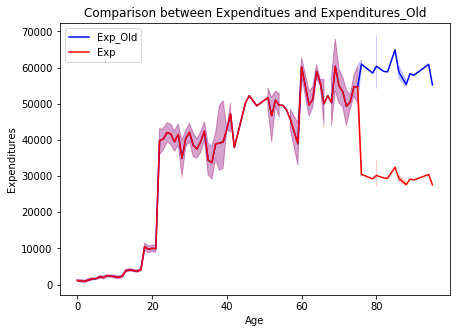

In [22]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(7, 5)
sns.lineplot(data=df, x="Age", y="Expenditures_Old", color='blue')
sns.lineplot(data=df, x="Age", y="Expenditures", color='red')
plt.title("Comparison between Expenditues and Expenditures_Old") 
plt.legend(labels=["Exp_Old","Exp"])
plt.show()

In [41]:
X = df[["Age", "Gender"]]
y = df["Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [42]:
X_train.shape

(621, 2)

In [43]:
param_grid = {
                'max_depth': [3], 
                'learning_rate': [.05], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [25, 30, 40, 50, 100, 150],
                'reg_gamma': [0.5]
}

xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid,cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


In [44]:
print_results(res, X_train, y_train, X_test, y_test)

XGB Model best params : {'random_state': 123, 'max_depth': 3, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'n_estimators': 100, 'reg_gamma': 0.5}
 Train RMSE: 3207.41317
 Test RMSE: 4012.14143


Text(0, 0.5, 'Features')

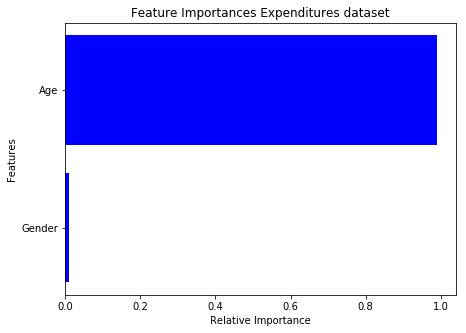

In [45]:
features = X_train.columns
importances = res.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')

### Adding monotone contraint on Age 

In [46]:
param_dict = param_grid
param_dict['monotone_constraints'] = ["(1,0)"]

In [47]:
xgbr_2 = xgb.XGBRegressor()
gr2 = GridSearchCV(xgbr_2,param_grid=param_dict,cv=5, verbose=True)
res2 = gr2.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


Text(0, 0.5, 'Features')

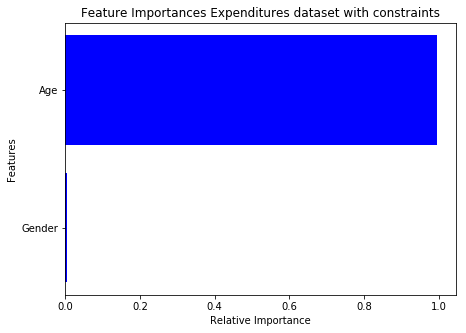

In [48]:
features = X_train.columns
importances = res2.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset with constraints')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')

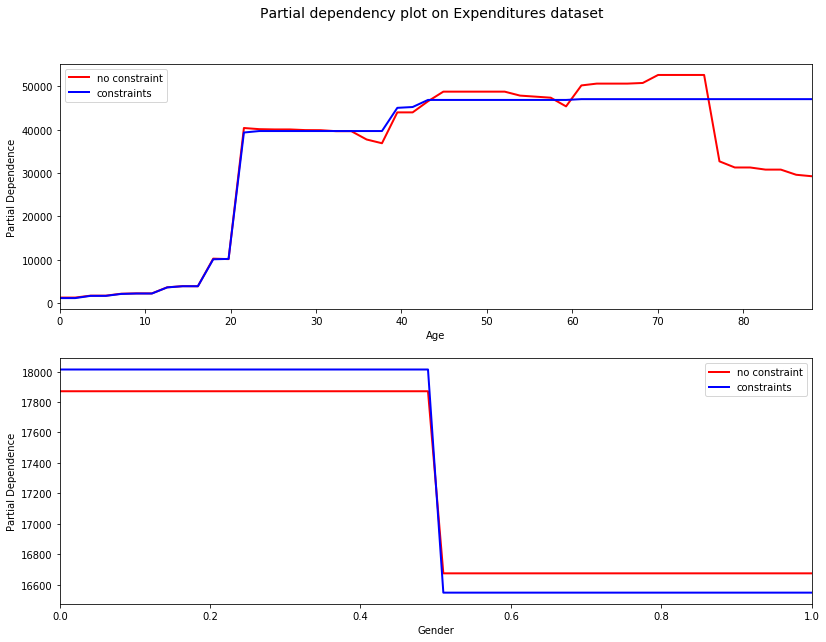

In [49]:
features = X_train.columns
fig, ax = plt.subplots(2,1)
fig.set_size_inches(12, 10)
fig.suptitle('Partial dependency plot on Expenditures dataset', fontsize=14)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, f in enumerate(features):
    grid, y_pred = get_partial_dependence(res, f, X_train, y_train)
    grid2, y_pred2 = get_partial_dependence(res2, f, X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    axis.plot(grid, y_pred, color = 'red', linewidth = 2, label='no constraint')
    axis.plot(grid2, y_pred2, color = 'blue', linewidth = 2, label='constraints')
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 10)
    axis.set_ylabel('Partial Dependence', fontsize = 10)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 10)

In [50]:
df['y_pred'] = res.predict(X)
df['y_pred2'] = res2.predict(X)

## Usecase 2: description

In [32]:
df['Age_plus'] = df['Age']
df.loc[df['Age']>75, 'Age_Plus'] = 75
df['Age_minus'] = df['Age']
df.loc[df['Age']<=75, 'Age_minus'] = 75
param_dict = param_grid
param_dict['monotone_constraints'] = ["(1,-1, 0)"]

In [33]:
X = df[["Age_plus", "Age_minus", "Gender"]]
y = df["Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)


xgbr_age_kink = xgb.XGBRegressor()
gr3 = GridSearchCV(xgbr_age_kink,param_grid=param_dict,cv=5, verbose=True)
age_kink_model = gr3.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


In [34]:
df['y_pred3'] = age_kink_model.predict(X)

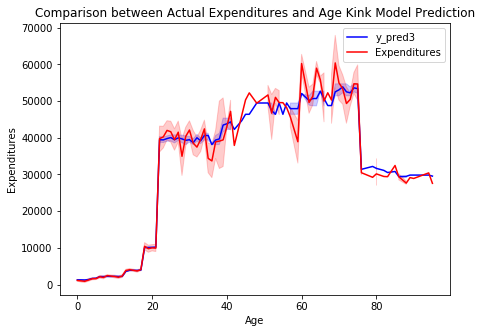

In [35]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(7, 5)
sns.lineplot(data=df, x="Age", y="y_pred3", color='blue')
sns.lineplot(data=df, x="Age", y="Expenditures", color='red')
plt.title("Comparison between Actual Expenditures and Age Kink Model Prediction") 
plt.legend(labels=["y_pred3","Expenditures"])
plt.show()

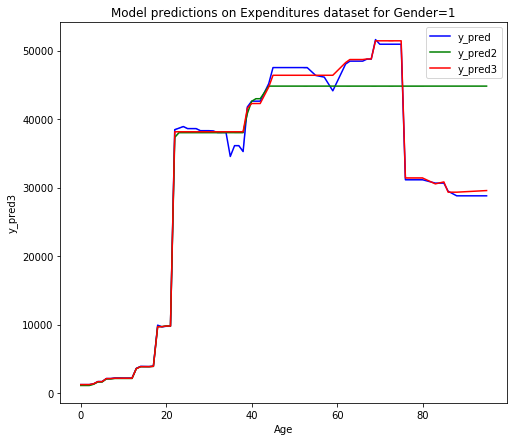

In [39]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(8, 7)
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred", color='blue')
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred2", color='green')
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred3", color='red')
plt.title("Model predictions on Expenditures dataset for Gender=1") 
plt.legend(labels=["y_pred","y_pred2", "y_pred3"])
plt.show()

## Usecase 3: Description

An example for implementing this usecase is the Boston Housing toy dataset imported from sklearn datasets. It has 506 rows and 13 attributes.To implement use case 1 we will create two XGBoost models one with no directional constraints and the second with a directional constraints on the RM, CRIM, NOX, DIS, PTRATIO and LSTAT attributes.

In [50]:
boston_dataset = load_boston()
print(boston_dataset.keys())

dict_keys(['target', 'DESCR', 'data', 'feature_names'])


In [51]:
print(boston_dataset.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [53]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.drop(columns=['B'], inplace=True)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [54]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

In [55]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [59]:
X, y = boston.iloc[:,:-1], boston.iloc[:,-1]
X_subset = X.drop(columns=['LSTAT'])
X_train, X_test, y_train, y_test = train_test_split(X_subset,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [60]:
param_grid = {
                'max_depth': [3], 
                'learning_rate': [.05], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [25, 30, 40, 50, 100, 150],
                'reg_gamma': [0.5]
}

xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid,cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.9s finished


Text(0.5, 0, 'Relative Importance')

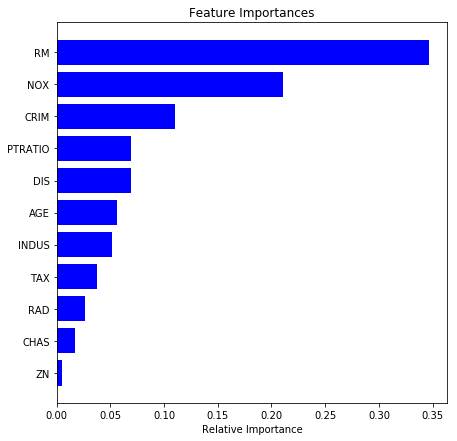

In [62]:
features = X_train.columns
importances = res.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.title('Feature Importances on Boston dataset')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')